In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy
from numpy.testing import assert_array_equal

import logging
logging.basicConfig(level=logging.INFO)

import atomlib
from atomlib.cell import Cell
from atomlib.visualize import show_atoms_3d, show_atoms_2d

In [4]:
a = 5.667
a_relax = 5.64244
a_relax_dft = 5.73545057088

cell = atomlib.make.zincblende('ZnSe', a, cell='conv') \
    .with_type({'Zn': 1, 'Se': 2})

cell.write_lmp("ZnSe_conv.lmp")

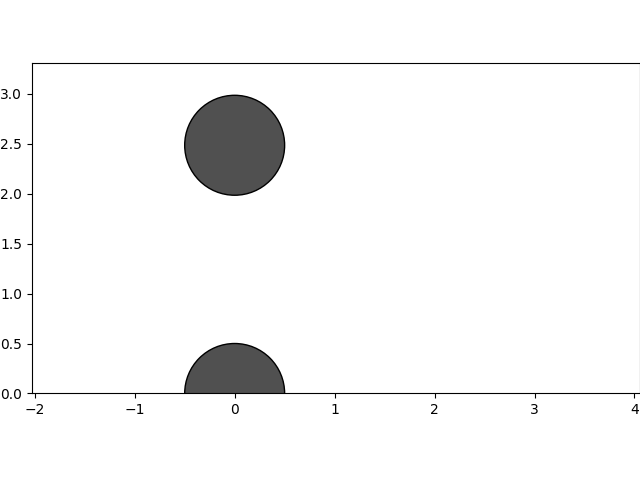

In [15]:
layer = atomlib.make.wurtzite('ZnSe', a_relax_dft * numpy.sqrt(2)/2, cell='prim')
layer = layer.with_cell(Cell.from_unit_cell(layer.get_cell().cell_size / [1, 1, 2], layer.cell_angle)).crop_to_box()

layer.write_xsf('ZnSe_layer_hex.xsf')

show_atoms_2d(layer, zone=[0, 1, 0], horz=[1, 0, 0]);

INFO:root:x: [-1 -1  2] transforms to [ 7.02446367e+00 -1.98339130e-16 -2.66453526e-15]
INFO:root:y: [-1  1  0] transforms to [-4.44089210e-16 -4.05557599e+00 -1.77635684e-15]
INFO:root:z: [1 1 1] transforms to [ 1.33226763e-15 -7.65303380e-16  9.93409179e+00]


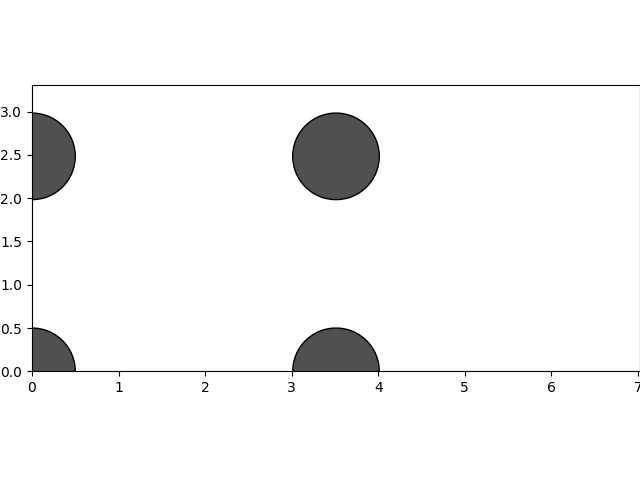

In [12]:
prim = atomlib.make.zincblende('ZnSe', a_relax_dft, cell='prim')

layer = atomlib.make.slab(prim, [1, 1, 1], [-1, -1, 0])
layer = layer.with_cell(Cell.from_unit_cell(layer.get_cell().cell_size / [1, 1, 3])).crop_to_box()
layer = layer.with_atoms(layer.get_atoms('cell_frac').round_near_zero(), 'cell_frac')

layer.write_xsf('ZnSe_layer.xsf')

show_atoms_2d(layer, zone=[0, 1, 0], horz=[1, 0, 0]);

In [13]:
layer

Cell size:  [7.02446367 4.05557599 3.31136393]
Cell angle: [1.57079633 1.57079633 1.57079633]
# Cells: [1 1 1]
Frame: cell_frac
Atoms, shape: (4, 3)
┌──────────────────┬──────┬────────┐
│ coords           ┆ elem ┆ symbol │
│ ---              ┆ ---  ┆ ---    │
│ array[f64, 3]    ┆ i8   ┆ str    │
╞══════════════════╪══════╪════════╡
│ [0.5, 0.5, 0.0]  ┆ 30   ┆ Zn     │
│ [0.5, 0.5, 0.75] ┆ 34   ┆ Se     │
│ [0.0, 0.0, 0.0]  ┆ 30   ┆ Zn     │
│ [0.0, 0.0, 0.75] ┆ 34   ┆ Se     │
└──────────────────┴──────┴────────┘

In [ ]:
atomlib.AtomCell(atomlib.Atoms({
    'x': [0.5, 0.5, 0., 0.],
    'y': [0.5, 0.5, 0., 0.],
    'z': [0.0, 0.75, 0., 0.75],
    'elem': [30, 34, 30, 34],
}), cell=Cell.from_unit_cell([6.941, 4.007, 3.272]), frame='cell_frac')

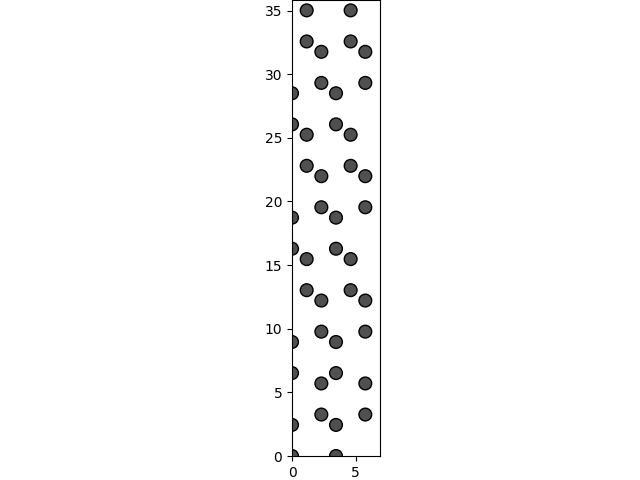

In [61]:
#shift_vec = layer.get_cell().cell_size * [0, 1, 0]
stack = atomlib.make.stacking_sequence(layer, "AB" + ("ABC" * 3))

show_atoms_2d(stack, zone=[0, 1, 0], horz=[1, 0, 0]);

stack.write_xsf("ZnSe_stack.xsf")
stack.repeat_to([50., 50., 1.]).write_xsf("ZnSe_stack_tiled.xsf")

INFO:root:Removing atoms.
INFO:root:Removed 192 atoms


len before: 1728
len after: 1343
len dedup: 1343


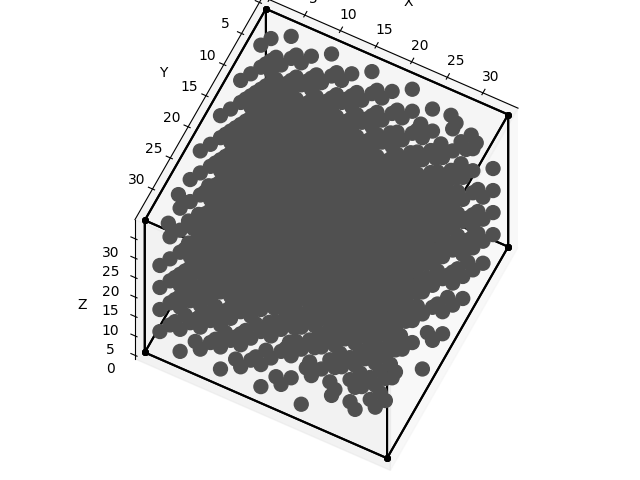

In [13]:
from atomlib.defect import stacking_fault

supercell = cell.repeat((6, 6, 6))

print(f"len before: {len(supercell)}")

faulted = stacking_fault(supercell, supercell.box_size * 0.5 + supercell.cell_size * 0.3, supercell.cell_size * [1, 1, 1] * -1 / 3., [1, 1, 1]) \
    .crop_atoms(0.01, 0.99, 0.01, 0.99, 0.01, 0.99, frame='cell_box')

print(f"len after: {len(faulted)}")

faulted = faulted.deduplicate()

print(f"len dedup: {len(faulted)}")

faulted.write_xsf("ZnSe_faulted_rm.xsf")

show_atoms_3d(faulted);
#show_atoms_3d(unshifted); show_atoms_3d(shifted);

In [35]:
pseudo_map = {'Zn': "zn_uspp_efficiency.upf", 'Se': "se_uspp_efficiency.upf"}

stack = atomlib.make.stacking_sequence(layer.repeat((2, 2, 1)), "ABCABC", [1, -1, 0])
stack.write_xsf("ZnSe_cell.xsf")
stack.write_qe("ZnSe_cell.qe", pseudo=pseudo_map)

stack = atomlib.make.stacking_sequence(layer.repeat((2, 2, 1)), "ABCABCB", [1, -1, 0])
stack.write_xsf("ZnSe_extrinsic.xsf")
stack.write_qe("ZnSe_extrinsic.qe", pseudo=pseudo_map)

stack = atomlib.make.stacking_sequence(layer.repeat((2, 2, 1)), "ABCABCAB", [1, -1, 0])
stack.write_xsf("ZnSe_intrinsic.xsf")
stack.write_qe("ZnSe_intrinsic.qe", pseudo=pseudo_map)